In [1]:
import pandas as pd
import numpy as np
import glob

In [2]:
path = 'crawl_json/'
frames = []
for filename in glob.glob(os.path.join(path, '*.json')): #only process .JSON files in folder.      
    with open(filename, encoding='utf-8', mode='r') as currentFile:
        frames.append(pd.read_json(currentFile, orient='index'))

df = pd.concat(frames)
df.drop(['authors', 'image_url', 'localpath', 'title_page', 'title_rss'], axis = 1, inplace = True)
df.head(2)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url
0,"06/09/2021, 10:14:38","06/09/2021, 10:14:38","03/28/2020, 14:58:03",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,"Denver Post poll: Most Coloradans support NRA,...",http://neighbors.denverpost.com/viewtopic.php?...
1,"06/09/2021, 10:14:38","06/09/2021, 10:14:38","03/28/2020, 16:15:00",Neighbors » Forums » Sports News » Denver Bron...,en,neighbors.denverpost.com,Neighbors » Forums » Sports News » Denver Bron...,Elvis Dumervil agrees to contract with Baltimo...,http://neighbors.denverpost.com/viewtopic.php?...


In [3]:
import nltk
from textblob import TextBlob
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
is_noun = lambda pos: pos[:2] == 'NN'
nouns = []
df['tokenized_words'] = df['maintext'].apply(nltk.word_tokenize)

for element in df["tokenized_words"]:
    nouns.append([word for (word, pos) in nltk.pos_tag(element) if is_noun(pos)]) 

df["nouns"] = nouns     #not optimal yet but doe the job

df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,tokenized_words,nouns
0,"06/09/2021, 10:14:38","06/09/2021, 10:14:38","03/28/2020, 14:58:03",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,"Denver Post poll: Most Coloradans support NRA,...",http://neighbors.denverpost.com/viewtopic.php?...,"[Neighbors, », Forums, », General, Discussion,...","[Neighbors, Forums, », General, Discussion, »,..."
1,"06/09/2021, 10:14:38","06/09/2021, 10:14:38","03/28/2020, 16:15:00",Neighbors » Forums » Sports News » Denver Bron...,en,neighbors.denverpost.com,Neighbors » Forums » Sports News » Denver Bron...,Elvis Dumervil agrees to contract with Baltimo...,http://neighbors.denverpost.com/viewtopic.php?...,"[Neighbors, », Forums, », Sports, News, », Den...","[Neighbors, Forums, », Sports, News, », Denver..."
2,"06/09/2021, 10:14:38","06/09/2021, 10:14:38","03/28/2020, 15:43:08",Art historian Kelly Grovier looks at images th...,en,www.bbc.com,Art historian Kelly Grovier looks at images t...,BBC - Culture - The painting that tricks the eye,http://www.bbc.com/culture/story/20160304-the-...,"[Art, historian, Kelly, Grovier, looks, at, im...","[Art, historian, Kelly, Grovier, images, frame..."


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [6]:
def vectorize_texts(list_of_strings):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(list_of_strings)
    transformer = TfidfTransformer(smooth_idf=False)
    tfidf = transformer.fit_transform(X)
    return tfidf  

In [7]:
all_article_nouns = []
for i, element in enumerate(nouns):
    for j in range(5): #range(len(element)):
        all_article_nouns.append(element[j])

vectorized_text = vectorize_texts(all_article_nouns)

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(vectorized_text)
dist

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

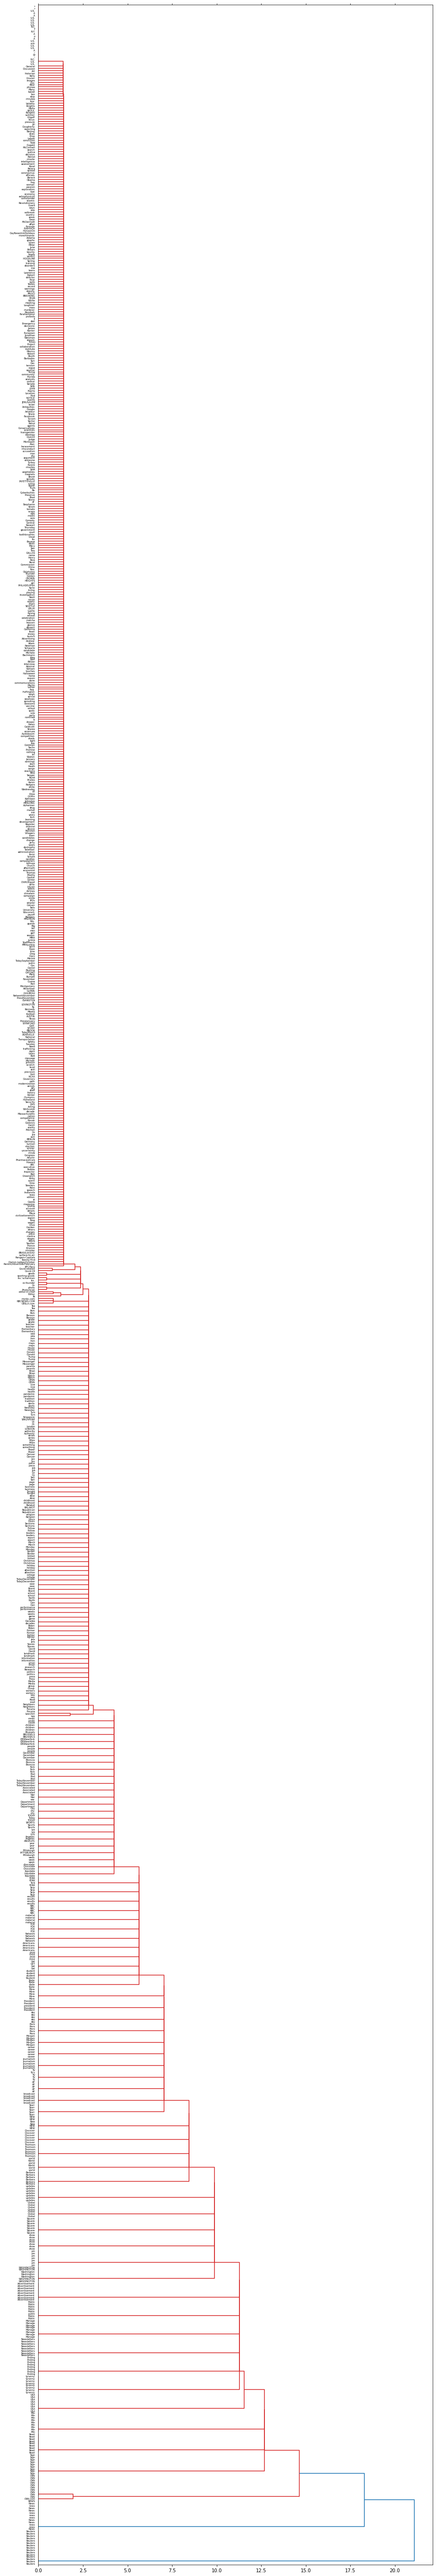

In [9]:
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt

linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(15, 100)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=all_article_nouns)

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.show()